In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50 
 # 32*68 = 2176

In [3]:
#Load Dataset

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

class_names = dataset.class_names
class_names


Found 2152 files belonging to 3 classes.


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

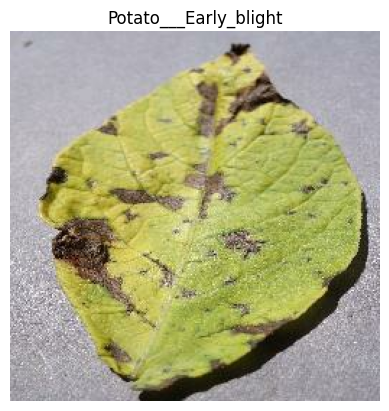

In [4]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[0]])

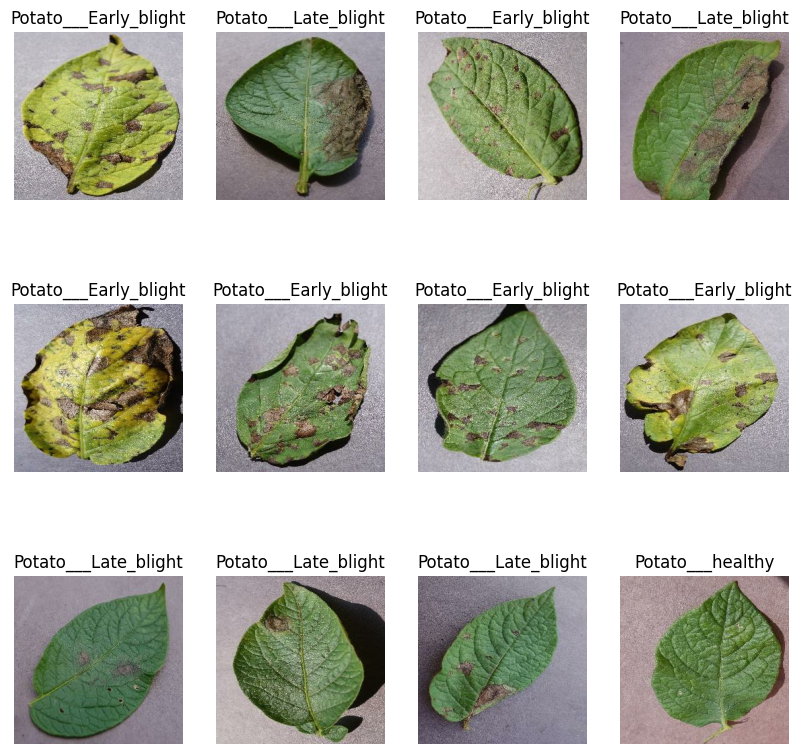

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
# Parition function

def get_dataset_partitions_tf(ds, train_split = 0.8, val_spilt = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)  
    val_size = int(val_spilt * ds_size)      

    train_ds = ds.take(train_size)          
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [7]:
# Performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [8]:
# preprocessing & augmentation

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([

    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    
    layers.Conv2D(512, (3, 3), activation='relu'),
    
    # Classification
    layers.GlobalAveragePooling2D(),  # Better than Flatten()
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])



model.build(input_shape = input_shape)


In [10]:

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [11]:
#compile & train

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds, 
    verbose = 1,
    epochs = 50
)

Epoch 1/50
54/54 [==============================] - 33s 286ms/step - loss: 0.9147 - accuracy: 0.4931 - val_loss: 0.7751 - val_accuracy: 0.5521
Epoch 2/50
54/54 [==============================] - 12s 223ms/step - loss: 0.7256 - accuracy: 0.6632 - val_loss: 0.6963 - val_accuracy: 0.6875
Epoch 3/50
54/54 [==============================] - 11s 201ms/step - loss: 0.6052 - accuracy: 0.7541 - val_loss: 0.4646 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 12s 220ms/step - loss: 0.4084 - accuracy: 0.8304 - val_loss: 0.6871 - val_accuracy: 0.7396
Epoch 5/50
54/54 [==============================] - 13s 234ms/step - loss: 0.3253 - accuracy: 0.8669 - val_loss: 0.3905 - val_accuracy: 0.8698
Epoch 6/50
54/54 [==============================] - 12s 230ms/step - loss: 0.2668 - accuracy: 0.9034 - val_loss: 0.1916 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 12s 228ms/step - loss: 0.1762 - accuracy: 0.9427 - val_loss: 0.1723 - val_accuracy: 0.9219

In [12]:
# Evaluate

scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 4s 76ms/step - loss: 0.0205 - accuracy: 0.9961


[0.020488113164901733, 0.99609375]

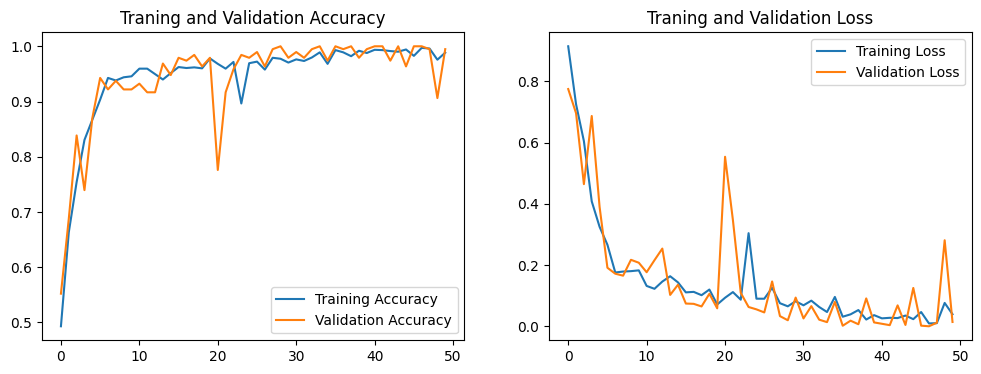

In [17]:
# history plots

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Traning and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title("Traning and Validation Loss")
plt.show()

First image to predict:


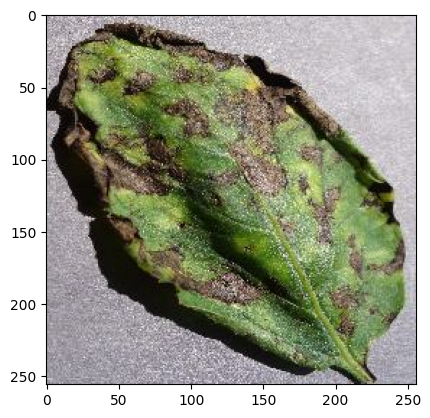

Actual label: Potato___Early_blight
1/1 [==============================] - 0s 42ms/step
Predicted label: Potato___Early_blight
Confidence: 100.00%
CORRECT PREDICTION


In [18]:
for images_batch, label_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    plt.show()
    
    print("Actual label:", class_names[first_label])

    # Get predictions
    batch_prediction = model.predict(images_batch)
    predicted_prob = batch_prediction[0]
    predicted_class = np.argmax(predicted_prob)
    confidence = np.max(predicted_prob) * 100
    
    print("Predicted label:", class_names[predicted_class])
    print(f"Confidence: {confidence:.2f}%")
    
    # Check if correct
    if first_label == predicted_class:
        print("CORRECT PREDICTION")
    else:
        print("WRONG PREDICTION")

In [19]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


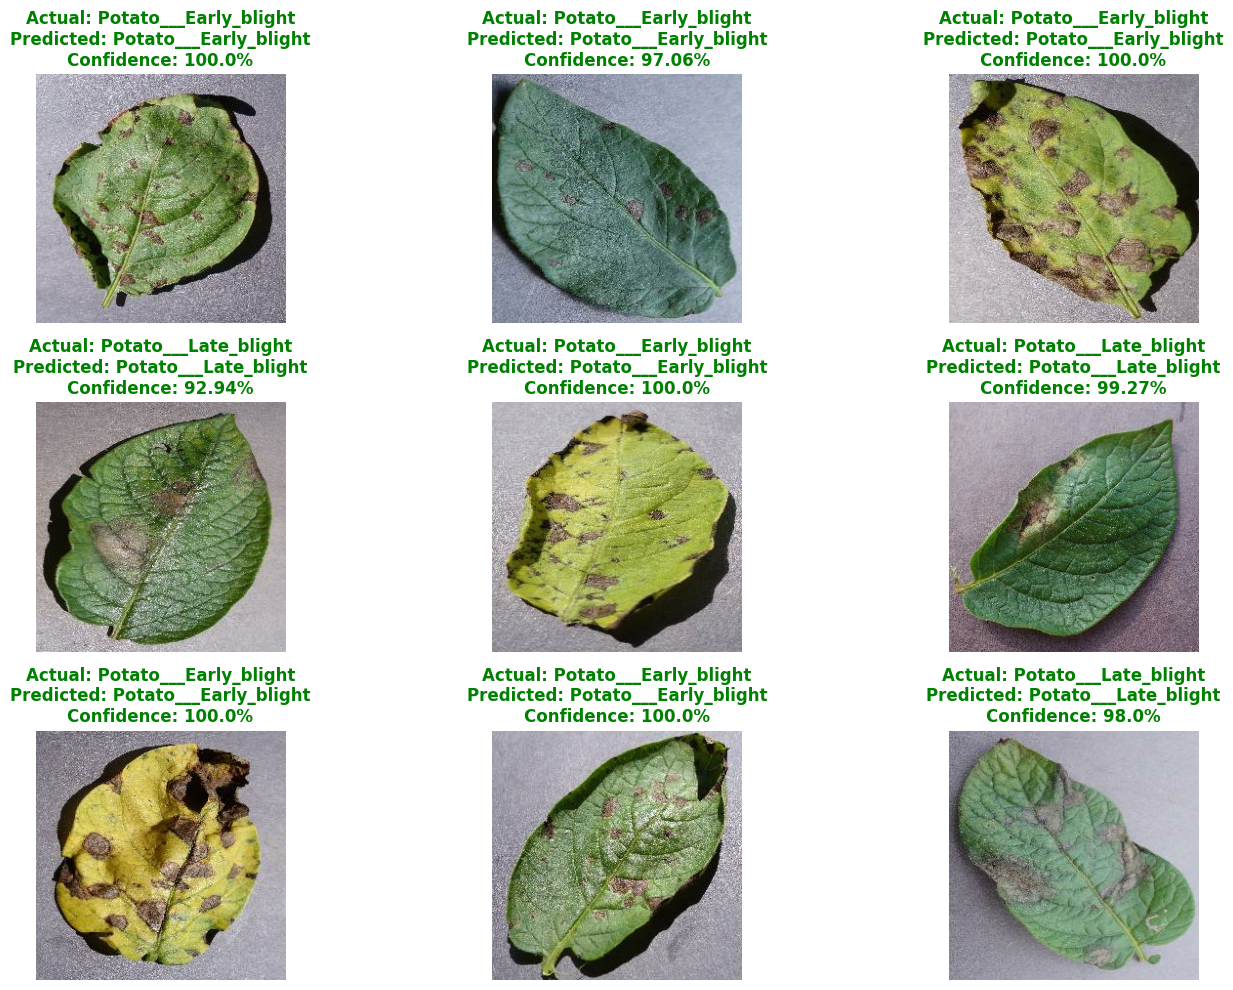

In [20]:
plt.figure(figsize=(15, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        # Color code based on correctness
        if actual_class == predicted_class:
            color = 'green'  # Correct prediction
        else:
            color = 'red'    # Wrong prediction
            
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", 
                 color=color, fontweight='bold')
        
        plt.axis("off")

plt.tight_layout()
plt.show()

In [21]:
model.save("potatoes.h5")

In [23]:
import os


path = "../Potato Disease Classification/saved_model"

# find the next version number
model_version = max([int(i) for i in os.listdir(path) if i.isdigit()] + [0]) + 1

# create new version folder
save_dir = f"{path}/{model_version}"
os.makedirs(save_dir, exist_ok=True)

#  SAVE IN TENSORFLOW SERVING FORMAT
tf.saved_model.save(model, save_dir)

print(f"Model saved successfully at: {save_dir}")


INFO:tensorflow:Assets written to: ../Potato Disease Classification/saved_model/1\assets


INFO:tensorflow:Assets written to: ../Potato Disease Classification/saved_model/1\assets


Model saved successfully at: ../Potato Disease Classification/saved_model/1
